# Regularización

Vamos a probar diferentes regularizaciones.

**Dataset**: vamos a utilizar el dataset cifar10.

**Modelo**: vamos a usar una CNN sencilla.

## Cargamos los datos

In [1]:
# Importar las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# Configurar el dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Definir las transformaciones para los casos sin data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar el dataset CIFAR-10 sin data augmentation
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Crear los loaders de datos
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
train_loader_eval = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)  # Para evaluación
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Usando dispositivo: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Definimos una CNN sencilla

In [2]:
# Definir la red neuronal convolucional
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Salida: 32 x 16 x 16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Salida: 64 x 8 x 8
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # Salida: 128 x 4 x 4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Definimos las funciones de entrenamiento y evaluación

In [3]:
# Definir las funciones de entrenamiento y evaluación
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, device, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            running_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Definir el número de épocas
num_epochs = 30

## 1 - Modelo sin regularización

In [4]:
# Configurar el modelo, criterio y optimizador sin regularización
model1 = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model1.parameters(), lr=0.01)

# Listas para almacenar las pérdidas y precisiones
train_losses_case1 = []
train_accs_case1 = []
val_losses_case1 = []
val_accs_case1 = []

# Entrenamiento del modelo
print("Entrenando el modelo sin regularización...")
for epoch in range(num_epochs):
    # Entrenamiento
    train_loss = train(model1, device, train_loader, optimizer1, criterion)
    
    # Evaluación en entrenamiento (con model.eval())
    train_loss_eval, train_acc = evaluate(model1, device, train_loader_eval, criterion)
    train_losses_case1.append(train_loss_eval)
    train_accs_case1.append(train_acc)
    
    # Evaluación en validación
    val_loss, val_acc = evaluate(model1, device, test_loader, criterion)
    val_losses_case1.append(val_loss)
    val_accs_case1.append(val_acc)
    
    print(f"Época {epoch+1}/{num_epochs}, Pérdida de Entrenamiento: {train_loss_eval:.4f}, Precisión de Entrenamiento: {train_acc:.4f}, "
          f"Pérdida de Validación: {val_loss:.4f}, Precisión de Validación: {val_acc:.4f}")



Entrenando el modelo sin regularización...
Época 1/30, Pérdida de Entrenamiento: 2.0439, Precisión de Entrenamiento: 0.2541, Pérdida de Validación: 2.0360, Precisión de Validación: 0.2588
Época 2/30, Pérdida de Entrenamiento: 1.8766, Precisión de Entrenamiento: 0.3293, Pérdida de Validación: 1.8793, Precisión de Validación: 0.3287
Época 3/30, Pérdida de Entrenamiento: 1.6184, Precisión de Entrenamiento: 0.4131, Pérdida de Validación: 1.6124, Precisión de Validación: 0.4122
Época 4/30, Pérdida de Entrenamiento: 1.4841, Precisión de Entrenamiento: 0.4550, Pérdida de Validación: 1.4855, Precisión de Validación: 0.4507
Época 5/30, Pérdida de Entrenamiento: 1.5269, Precisión de Entrenamiento: 0.4429, Pérdida de Validación: 1.5283, Precisión de Validación: 0.4428
Época 6/30, Pérdida de Entrenamiento: 1.6310, Precisión de Entrenamiento: 0.4352, Pérdida de Validación: 1.6341, Precisión de Validación: 0.4322
Época 7/30, Pérdida de Entrenamiento: 1.2663, Precisión de Entrenamiento: 0.5491, Pérdi

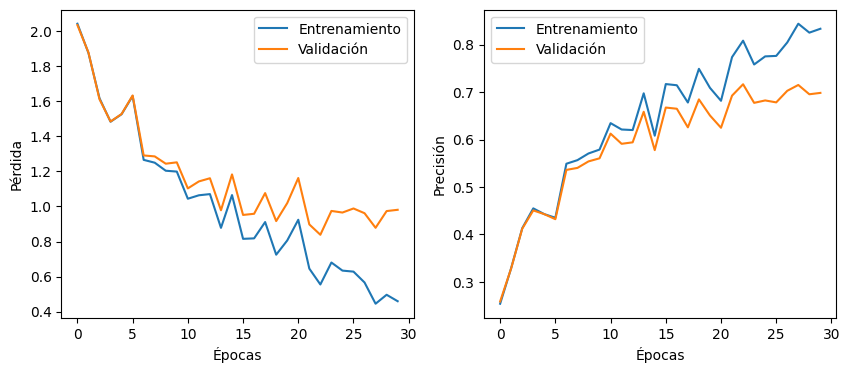

In [5]:
# Curvas de entrenamiento y validación
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_case1, label='Entrenamiento')
plt.plot(val_losses_case1, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs_case1, label='Entrenamiento')
plt.plot(val_accs_case1, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

## 2- Regularización L1

La regularización L1 agrega una penalización proporcional a la suma de los valores absolutos de los pesos al término de pérdida.
 
Fórmula de la regularización L1:
$$
L_{total} = L_{data} + \lambda \sum_{i} |w_i|
$$
Donde:
- $L_{data}$ es la pérdida original (por ejemplo, CrossEntropyLoss).
- $\lambda$ es el factor de regularización.
- $w_i$ son los pesos del modelo.

In [6]:
# -----------------------------------------------------------
# Regularización L1
# -----------------------------------------------------------

# Función para calcular la regularización L1
def l1_regularization(model, lambda_l1):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1 * l1_norm

# Configurar el modelo, criterio y optimizador
model2 = SimpleCNN().to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01)
lambda_l1 = 1e-5  # Factor de regularización L1

# Listas para almacenar las pérdidas y precisiones
train_losses_case2 = []
train_accs_case2 = []
val_losses_case2 = []
val_accs_case2 = []

# Entrenamiento del modelo con regularización L1
print("Entrenando el modelo con regularización L1...")
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer2.zero_grad()
        outputs = model2(data)
        loss = criterion(outputs, target)
        
        # Añadir regularización L1
        l1_loss = l1_regularization(model2, lambda_l1)
        loss += l1_loss
        
        loss.backward()
        optimizer2.step()
        
        running_loss += loss.item() * data.size(0)
    
    # Evaluación en entrenamiento
    train_loss_eval, train_acc = evaluate(model2, device, train_loader_eval, criterion)
    train_losses_case2.append(train_loss_eval)
    train_accs_case2.append(train_acc)
    
    # Evaluación en validación
    val_loss, val_acc = evaluate(model2, device, test_loader, criterion)
    val_losses_case2.append(val_loss)
    val_accs_case2.append(val_acc)
    
    print(f"Época {epoch+1}/{num_epochs}, Pérdida de Entrenamiento: {train_loss_eval:.4f}, Precisión de Entrenamiento: {train_acc:.4f}, "
          f"Pérdida de Validación: {val_loss:.4f}, Precisión de Validación: {val_acc:.4f}")

Entrenando el modelo con regularización L1...
Época 1/30, Pérdida de Entrenamiento: 2.0535, Precisión de Entrenamiento: 0.2734, Pérdida de Validación: 2.0502, Precisión de Validación: 0.2782
Época 2/30, Pérdida de Entrenamiento: 1.7589, Precisión de Entrenamiento: 0.3640, Pérdida de Validación: 1.7567, Precisión de Validación: 0.3667
Época 3/30, Pérdida de Entrenamiento: 1.7679, Precisión de Entrenamiento: 0.3776, Pérdida de Validación: 1.7673, Precisión de Validación: 0.3709
Época 4/30, Pérdida de Entrenamiento: 1.6837, Precisión de Entrenamiento: 0.4056, Pérdida de Validación: 1.6790, Precisión de Validación: 0.4030
Época 5/30, Pérdida de Entrenamiento: 1.3856, Precisión de Entrenamiento: 0.5040, Pérdida de Validación: 1.3938, Precisión de Validación: 0.4981
Época 6/30, Pérdida de Entrenamiento: 1.3827, Precisión de Entrenamiento: 0.5021, Pérdida de Validación: 1.3970, Precisión de Validación: 0.4934
Época 7/30, Pérdida de Entrenamiento: 1.3089, Precisión de Entrenamiento: 0.5278, Pé

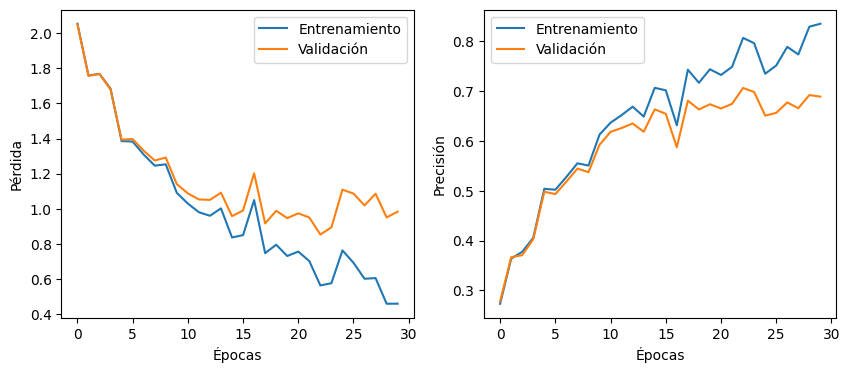

In [7]:
# Curvas de entrenamiento y validación
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_case2, label='Entrenamiento')
plt.plot(val_losses_case2, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs_case2, label='Entrenamiento')
plt.plot(val_accs_case2, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

## 3 - Regularización L2

La regularización L2 agrega una penalización proporcional al cuadrado de los pesos al término de pérdida.
 
Fórmula de la regularización L2:
$$
L_{total} = L_{data} + \lambda \sum_{i} w_i^2
$$
Donde:
- $L_{data}$ es la pérdida original.
- $\lambda$ es el factor de regularización.
- $w_i$ son los pesos del modelo.

En PyTorch, la regularización L2 se implementa mediante el parámetro `weight_decay` en el optimizador.


In [8]:
# -----------------------------------------------------------
# Regularización L2
# -----------------------------------------------------------

# Configurar el modelo, criterio y optimizador con weight_decay
model3 = SimpleCNN().to(device)
optimizer3 = optim.SGD(model3.parameters(), lr=0.01, weight_decay=1e-4)  # Factor de regularización L2

# Listas para almacenar las pérdidas y precisiones
train_losses_case3 = []
train_accs_case3 = []
val_losses_case3 = []
val_accs_case3 = []

# Entrenamiento del modelo con regularización L2
print("Entrenando el modelo con regularización L2...")
for epoch in range(num_epochs):
    # Entrenamiento
    train_loss = train(model3, device, train_loader, optimizer3, criterion)
    
    # Evaluación en entrenamiento
    train_loss_eval, train_acc = evaluate(model3, device, train_loader_eval, criterion)
    train_losses_case3.append(train_loss_eval)
    train_accs_case3.append(train_acc)
    
    # Evaluación en validación
    val_loss, val_acc = evaluate(model3, device, test_loader, criterion)
    val_losses_case3.append(val_loss)
    val_accs_case3.append(val_acc)
    
    print(f"Época {epoch+1}/{num_epochs}, Pérdida de Entrenamiento: {train_loss_eval:.4f}, Precisión de Entrenamiento: {train_acc:.4f}, "
          f"Pérdida de Validación: {val_loss:.4f}, Precisión de Validación: {val_acc:.4f}")


Entrenando el modelo con regularización L2...
Época 1/30, Pérdida de Entrenamiento: 2.0538, Precisión de Entrenamiento: 0.2593, Pérdida de Validación: 2.0437, Precisión de Validación: 0.2685
Época 2/30, Pérdida de Entrenamiento: 1.8560, Precisión de Entrenamiento: 0.3249, Pérdida de Validación: 1.8440, Precisión de Validación: 0.3266
Época 3/30, Pérdida de Entrenamiento: 1.9310, Precisión de Entrenamiento: 0.3287, Pérdida de Validación: 1.9168, Precisión de Validación: 0.3255
Época 4/30, Pérdida de Entrenamiento: 1.4845, Precisión de Entrenamiento: 0.4633, Pérdida de Validación: 1.4850, Precisión de Validación: 0.4600
Época 5/30, Pérdida de Entrenamiento: 1.3838, Precisión de Entrenamiento: 0.5038, Pérdida de Validación: 1.3887, Precisión de Validación: 0.5021
Época 6/30, Pérdida de Entrenamiento: 1.5515, Precisión de Entrenamiento: 0.4592, Pérdida de Validación: 1.5612, Precisión de Validación: 0.4517
Época 7/30, Pérdida de Entrenamiento: 1.2874, Precisión de Entrenamiento: 0.5453, Pé

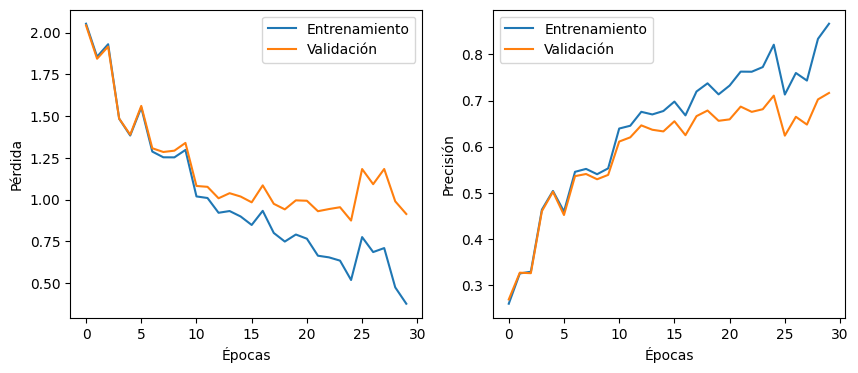

In [9]:
# Curvas de entrenamiento y validación
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_case3, label='Entrenamiento')
plt.plot(val_losses_case3, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs_case3, label='Entrenamiento')
plt.plot(val_accs_case3, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

## 4 - Dropout

Dropout es una técnica de regularización que consiste en apagar aleatoriamente neuronas durante el entrenamiento. Esto previene que las neuronas co-adapten demasiado y ayuda a reducir el sobreajuste.

Durante la evaluación (inferencia), se desactiva el dropout para utilizar toda la capacidad del modelo.

In [10]:
# -----------------------------------------------------------
# Dropout
# -----------------------------------------------------------

# Definir el modelo con capas Dropout
class SimpleCNNWithDropout(nn.Module):
    def __init__(self):
        super(SimpleCNNWithDropout, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2),  # Salida: 32 x 16 x 16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2),  # Salida: 64 x 8 x 8
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2)   # Salida: 128 x 4 x 4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Configurar el modelo, criterio y optimizador
model4 = SimpleCNNWithDropout().to(device)
optimizer4 = optim.SGD(model4.parameters(), lr=0.01)

# Listas para almacenar las pérdidas y precisiones
train_losses_case4 = []
train_accs_case4 = []
val_losses_case4 = []
val_accs_case4 = []

# Entrenamiento del modelo con Dropout
print("Entrenando el modelo con Dropout...")
for epoch in range(num_epochs):
    # Entrenamiento
    train_loss = train(model4, device, train_loader, optimizer4, criterion)
    
    # Evaluación en entrenamiento
    train_loss_eval, train_acc = evaluate(model4, device, train_loader_eval, criterion)
    train_losses_case4.append(train_loss_eval)
    train_accs_case4.append(train_acc)
    
    # Evaluación en validación
    val_loss, val_acc = evaluate(model4, device, test_loader, criterion)
    val_losses_case4.append(val_loss)
    val_accs_case4.append(val_acc)
    
    print(f"Época {epoch+1}/{num_epochs}, Pérdida de Entrenamiento: {train_loss_eval:.4f}, Precisión de Entrenamiento: {train_acc:.4f}, "
          f"Pérdida de Validación: {val_loss:.4f}, Precisión de Validación: {val_acc:.4f}")

Entrenando el modelo con Dropout...
Época 1/30, Pérdida de Entrenamiento: 2.0435, Precisión de Entrenamiento: 0.3061, Pérdida de Validación: 2.0381, Precisión de Validación: 0.3080
Época 2/30, Pérdida de Entrenamiento: 1.8165, Precisión de Entrenamiento: 0.4205, Pérdida de Validación: 1.8119, Precisión de Validación: 0.4199
Época 3/30, Pérdida de Entrenamiento: 1.6867, Precisión de Entrenamiento: 0.4536, Pérdida de Validación: 1.6817, Precisión de Validación: 0.4504
Época 4/30, Pérdida de Entrenamiento: 1.5828, Precisión de Entrenamiento: 0.4954, Pérdida de Validación: 1.5809, Precisión de Validación: 0.4983
Época 5/30, Pérdida de Entrenamiento: 1.5499, Precisión de Entrenamiento: 0.5181, Pérdida de Validación: 1.5528, Precisión de Validación: 0.5123
Época 6/30, Pérdida de Entrenamiento: 1.5211, Precisión de Entrenamiento: 0.4954, Pérdida de Validación: 1.5245, Precisión de Validación: 0.4889
Época 7/30, Pérdida de Entrenamiento: 1.4033, Precisión de Entrenamiento: 0.5688, Pérdida de V

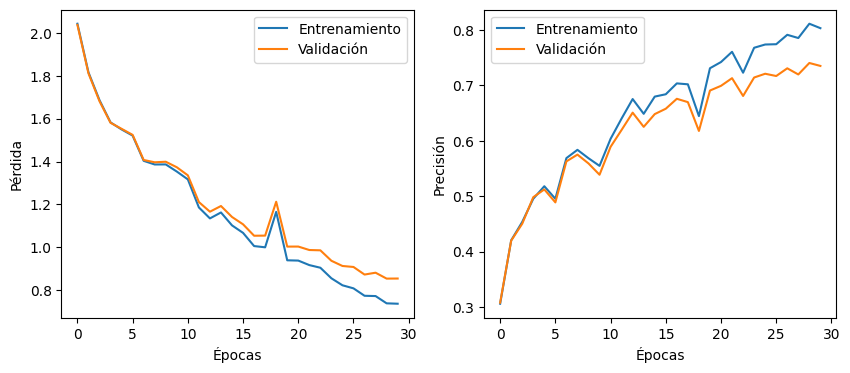

In [11]:
# Curvas de entrenamiento y validación
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_case4, label='Entrenamiento')
plt.plot(val_losses_case4, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs_case4, label='Entrenamiento')
plt.plot(val_accs_case4, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

## 5 - Data augmentation y early stopping

El Data Augmentation aumenta la diversidad del conjunto de entrenamiento aplicando transformaciones aleatorias a las imágenes, como rotaciones, volteos, recortes, etc.

Early Stopping: se detiene el entrenamiento cuando una métrica de validación deja de mejorar o cuando ciertas condiciones se cumplen, para prevenir el sobreajuste.

In [12]:
# -----------------------------------------------------------
# Data Augmentation
# -----------------------------------------------------------

# Definir las transformaciones con data augmentation
transform_train_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar el dataset CIFAR-10 con data augmentation
train_dataset_augmented = datasets.CIFAR10(root='./data', train=True, transform=transform_train_augmented, download=True)
train_loader_augmented = DataLoader(dataset=train_dataset_augmented, batch_size=batch_size, shuffle=True)
train_loader_augmented_eval = DataLoader(dataset=train_dataset_augmented, batch_size=batch_size, shuffle=False)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Configurar el modelo, criterio y optimizador
model5 = SimpleCNN().to(device)
optimizer5 = optim.SGD(model5.parameters(), lr=0.01)

# Listas para almacenar las pérdidas y precisiones
train_losses_case5 = []
train_accs_case5 = []
val_losses_case5 = []
val_accs_case5 = []

# Entrenamiento del modelo con data augmentation y early stopping
print("Entrenando el modelo con Data Augmentation y Early Stopping...")
for epoch in range(num_epochs):
    # Entrenamiento
    train_loss = train(model5, device, train_loader_augmented, optimizer5, criterion)
    
    # Evaluación en entrenamiento
    train_loss_eval, train_acc = evaluate(model5, device, train_loader_augmented_eval, criterion)
    train_losses_case5.append(train_loss_eval)
    train_accs_case5.append(train_acc)
    
    # Evaluación en validación
    val_loss, val_acc = evaluate(model5, device, test_loader, criterion)
    val_losses_case5.append(val_loss)
    val_accs_case5.append(val_acc)
    
    print(f"Época {epoch+1}/{num_epochs}, Pérdida de Entrenamiento: {train_loss_eval:.4f}, Precisión de Entrenamiento: {train_acc:.4f}, "
          f"Pérdida de Validación: {val_loss:.4f}, Precisión de Validación: {val_acc:.4f}")
    
    # Condición de Early Stopping
    if val_acc > 0.6 and (train_acc - val_acc) > 0.05:
        print("Condición de early stopping alcanzada.")
        break

Files already downloaded and verified
Files already downloaded and verified
Entrenando el modelo con Data Augmentation y Early Stopping...
Época 1/30, Pérdida de Entrenamiento: 2.2028, Precisión de Entrenamiento: 0.2224, Pérdida de Validación: 2.1881, Precisión de Validación: 0.2552
Época 2/30, Pérdida de Entrenamiento: 1.9242, Precisión de Entrenamiento: 0.2983, Pérdida de Validación: 1.8761, Precisión de Validación: 0.3210
Época 3/30, Pérdida de Entrenamiento: 1.7825, Precisión de Entrenamiento: 0.3451, Pérdida de Validación: 1.7300, Precisión de Validación: 0.3684
Época 4/30, Pérdida de Entrenamiento: 1.6747, Precisión de Entrenamiento: 0.3882, Pérdida de Validación: 1.6003, Precisión de Validación: 0.4190
Época 5/30, Pérdida de Entrenamiento: 1.5607, Precisión de Entrenamiento: 0.4256, Pérdida de Validación: 1.5020, Precisión de Validación: 0.4500
Época 6/30, Pérdida de Entrenamiento: 1.5496, Precisión de Entrenamiento: 0.4325, Pérdida de Validación: 1.4334, Precisión de Validación

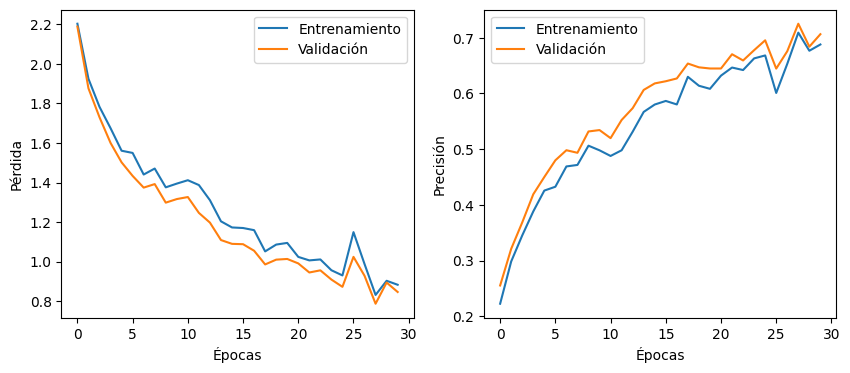

In [13]:
# Curvas de entrenamiento y validación
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_case5, label='Entrenamiento')
plt.plot(val_losses_case5, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs_case5, label='Entrenamiento')
plt.plot(val_accs_case5, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

## Comparación de curvas de entrenamiento

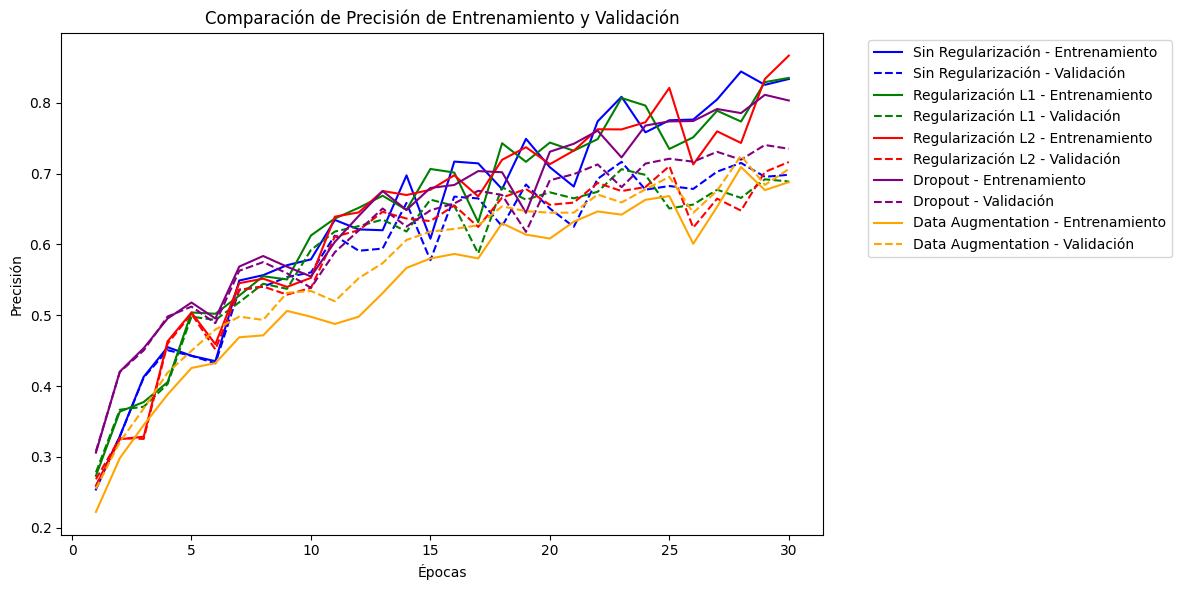

In [14]:
# Crear listas de épocas para cada caso
epochs_case1 = range(1, len(train_accs_case1) + 1)
epochs_case2 = range(1, len(train_accs_case2) + 1)
epochs_case3 = range(1, len(train_accs_case3) + 1)
epochs_case4 = range(1, len(train_accs_case4) + 1)
epochs_case5 = range(1, len(train_accs_case5) + 1)

# Configurar el estilo de las líneas
styles = ['-', '--']  # Línea sólida para entrenamiento, punteada para validación
colors = ['blue', 'green', 'red', 'purple', 'orange']
labels = ['Sin Regularización', 'Regularización L1', 'Regularización L2', 'Dropout', 'Data Augmentation']

# Graficar las curvas de precisión
plt.figure(figsize=(12, 6))

# Caso 1
plt.plot(epochs_case1, train_accs_case1, linestyle=styles[0], color=colors[0], label=f'{labels[0]} - Entrenamiento')
plt.plot(epochs_case1, val_accs_case1, linestyle=styles[1], color=colors[0], label=f'{labels[0]} - Validación')

# Caso 2
plt.plot(epochs_case2, train_accs_case2, linestyle=styles[0], color=colors[1], label=f'{labels[1]} - Entrenamiento')
plt.plot(epochs_case2, val_accs_case2, linestyle=styles[1], color=colors[1], label=f'{labels[1]} - Validación')

# Caso 3
plt.plot(epochs_case3, train_accs_case3, linestyle=styles[0], color=colors[2], label=f'{labels[2]} - Entrenamiento')
plt.plot(epochs_case3, val_accs_case3, linestyle=styles[1], color=colors[2], label=f'{labels[2]} - Validación')

# Caso 4
plt.plot(epochs_case4, train_accs_case4, linestyle=styles[0], color=colors[3], label=f'{labels[3]} - Entrenamiento')
plt.plot(epochs_case4, val_accs_case4, linestyle=styles[1], color=colors[3], label=f'{labels[3]} - Validación')

# Caso 5
plt.plot(epochs_case5, train_accs_case5, linestyle=styles[0], color=colors[4], label=f'{labels[4]} - Entrenamiento')
plt.plot(epochs_case5, val_accs_case5, linestyle=styles[1], color=colors[4], label=f'{labels[4]} - Validación')

plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Comparación de Precisión de Entrenamiento y Validación')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
